# 画图：观察不同BatchSize

In [1]:
import pandas as pd
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("stupidtree/[EXP]BiSR-batch_size")

summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })


In [5]:
summary_list

[{'client0_step_loss': 1.1472513675689695,
  'client0_local_epoch': 0,
  'client0_DLG_raw_rgLf_sampled': 0.3534741949856252,
  'client0_avg_loss': 1.2055993795394897,
  'client0_test-ppl': 101.8084945678711,
  'client0_DLG_rgL_f_sampled': 0.9435093151041708,
  'client0_DRA_b2tr_rgLf_avg': 0.9358076322157256,
  'client0_DRA_b2tr_rgLf_sampled': 0.9366582406118734,
  'global_step': 809,
  '_runtime': 1714.001007795334,
  '_timestamp': 1711840549.5061238,
  'client0_self': 0.0003881497335049975,
  'client0_DLG_raw_rgLf_avg': 0.3277730153257005,
  '_step': 809,
  'client0_local_step': 809,
  'client0_global_round': 0,
  'client0_DLG_rgL_f_avg': 0.9415315935663048,
  'client0_attacker_b2tr_step': 0.9313718497629344,
  '_wandb': {'runtime': 1713}},
 {'_timestamp': 1711838795.8404243,
  'global_step': 809,
  'client0_DRA_b2tr_rgLf_avg': 0.9375950794623976,
  'client0_attacker_b2tr_step': 0.9037164042831454,
  'client0_DLG_raw_rgLf_sampled': 0.35605145413544165,
  '_step': 809,
  'client0_avg_l

In [22]:
res = list(zip(config_list,summary_list))

bs = [r[0]['batch_size'] for r in res]
rgs_dra = [r[1]['client0_DRA_b2tr_rgLf_avg'] for r in res]
rgs_tag = [r[1]['client0_DLG_raw_rgLf_avg'] for r in res]
rgs_ours = [r[1]['client0_DLG_rgL_f_avg'] for r in res]

all_data = {'SDRP-only':rgs_dra, 'TAG-only':rgs_tag, 'BiSR':rgs_ours}

In [23]:
all_data

{'SDRP-only': [0.9358076322157256,
  0.9375950794623976,
  0.9386547178057564,
  0.9372118910808364,
  0.9261703271183712,
  0.9334936120983472,
  0.9312278732915698,
  0.93258165864998,
  0.9326500487459606,
  0.9314317381750434,
  0.9334233151731054,
  0.9358128677773194,
  0.9309447553799656,
  0.9332881628484748],
 'TAG-only': [0.3277730153257005,
  0.3320586609116952,
  0.33107527959737404,
  0.33195652986650054,
  0.34085633229947243,
  0.3514673980916027,
  0.3580909667646364,
  0.3849028552023107,
  0.39461452260916713,
  0.40167275682117154,
  0.4579455449565597,
  0.5291039207731298,
  0.6422415093230252,
  0.95717574454625],
 'BiSR': [0.9415315935663048,
  0.9441859669047966,
  0.9450961667505472,
  0.9445018757539912,
  0.9350630413530436,
  0.9408061122711,
  0.9402776881159828,
  0.9419559005928886,
  0.9463989050885546,
  0.9428680195255756,
  0.9472775546076756,
  0.9568723669333512,
  0.9551108583981576,
  0.9788407661330788]}

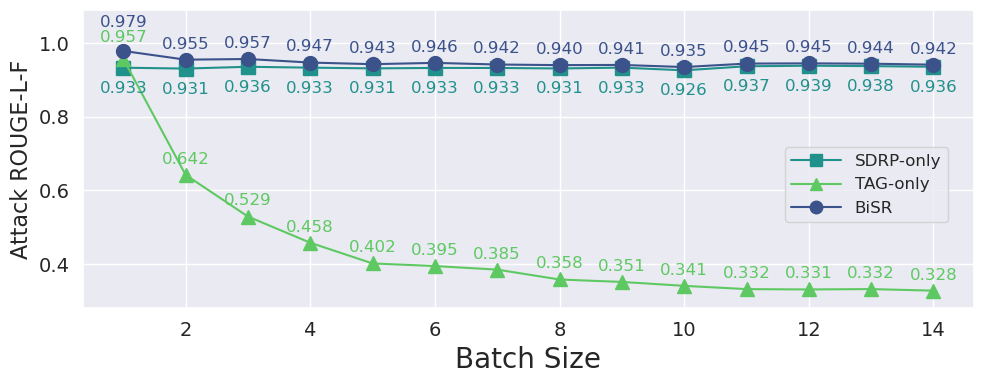

In [50]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()
fig,ax = plt.subplots(figsize=(10,4))
colors = sns.color_palette("viridis", 3)
color_dict = {'SDRP-only':colors[1], 'TAG-only':colors[2], 'BiSR':colors[0]}
marker_dict = {'SDRP-only':'s', 'TAG-only':'^', 'BiSR':'o'}
for name, rouges in all_data.items():
    ax.plot(bs, rouges, color=color_dict[name], label=name, marker=marker_dict[name],markersize=10)
    for b, txt in zip(bs, rouges):
        pos = 8
        if name == 'SDRP-only':
            pos = -18
        elif name == 'BiSR' and b ==1:
            pos = 17
        elif name == 'TAG-only' and b == 1:
            pos = 12
        ax.annotate(f'{txt:.3f}', (b, txt), textcoords="offset points", xytext=(0, pos),
                             ha='center', fontsize=12, color=color_dict[name])

ax.set_ylabel('Attack ROUGE-L-F', fontsize=16)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel('Batch Size', fontsize=20)
ax.tick_params(axis='x', labelsize=14)
ax.set_ylim(0.28, 1.09)

plt.legend(fontsize=12, ncol=1, loc='lower right', bbox_to_anchor=(0.98, 0.26),
           markerscale=0.9, handlelength=3.0)

plt.tight_layout()
plt.savefig('/root/autodl-tmp/sfl/exp_data/diff_batch_size.pdf')